<a href="https://colab.research.google.com/github/HeadOutii/AIRepair/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow numpy pandas matplotlib opencv-python kaggle

In [2]:
# Импорт необходимых библиотек
import kagglehub
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [3]:
path = kagglehub.dataset_download("bharatadhikari/humanface8000")
print("Path to dataset files:", path)
image_folder = os.path.join(path, 'landscape Images/gray')
mask_folder = os.path.join(path, 'landscape Images/color')

100%|██████████| 475M/475M [00:03<00:00, 130MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bharatadhikari/humanface8000/versions/1


In [4]:
IMAGE_SIZE = (128, 128)
NUM_IMAGES = 8000
BATCH_SIZE = 64
EPOCHS = 20

In [5]:
# ЗАгрузка изображений из папки
def load_images(folder, num_images, target_size):

    images = []
    for filename in os.listdir(folder)[:num_images]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)

In [6]:
# Загрузка набора данных
gray_images = load_images(os.path.join(image_folder), NUM_IMAGES, IMAGE_SIZE)
color_images = load_images(os.path.join(mask_folder), NUM_IMAGES, IMAGE_SIZE)

In [7]:
# Нормализация
gray_images = gray_images.astype('float32') / 255.0
color_images = color_images.astype('float32') / 255.0

In [8]:
# Разделение набора данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.2, random_state=42)

In [9]:
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [10]:
def create_resnet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=1, padding='same', activation='relu')(inputs)

    # Residual blocks
    for _ in range(5):
        x = residual_block(x, 64)

    # Дополнительные слои для выхода
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(3, (1, 1), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

model = create_resnet_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Обучнений модели
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test)
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 724ms/step - loss: 0.0379 - val_loss: 0.0109
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 692ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 693ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 687ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 674ms/step - loss: 0.0124 - val_loss: 0.0273
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 670ms/step - loss: 0.0188 - val_loss: 0.0103
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 674ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 669ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 665ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 667ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 674ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 12/20
100/10

In [ ]:
# Сохранение модели
model.save('image_restoration_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


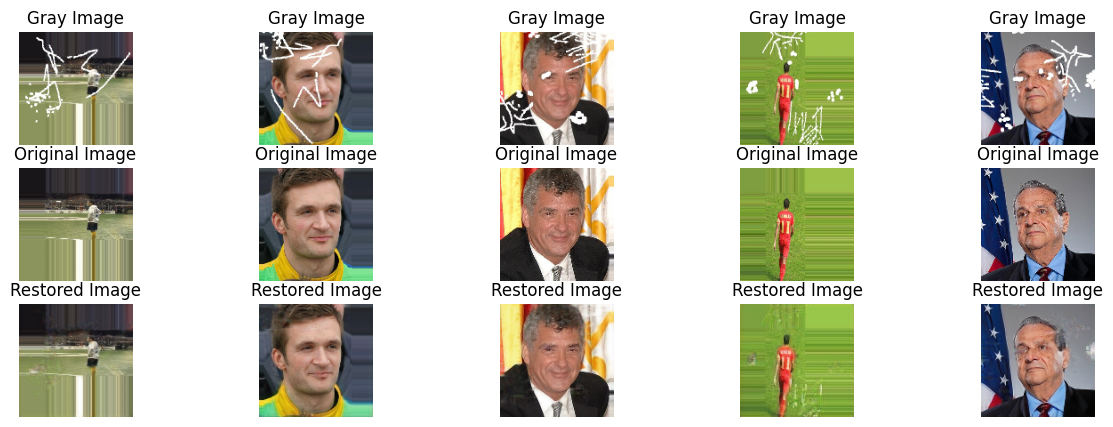

In [12]:
# Визуализация
def visualize_results(X_test, y_test, model, num_images=5):

    preds = model.predict(X_test[:num_images])

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title("Gray Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(y_test[i])
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(preds[i])
        plt.title("Restored Image")
        plt.axis('off')

    plt.show()

visualize_results(X_test, y_test, model)